In [78]:
import os
from datetime import datetime
import numpy as np
import pandas as pd

from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import backend as K
#from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import shutil

%matplotlib inline

In [79]:
# Input data files are available in the "../data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data"))
train_dir = "C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/"
test_dir = "C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/test"
valid_dir = "C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/"
print("Number of training examples: ", len(os.listdir('C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/0')) 
      + len(os.listdir('C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/1')))
print("Number of test examples: ", len(os.listdir('C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/test/images')))

# see training distribution
df_train = pd.read_csv('C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train_labels.csv',dtype=str)
print(df_train.head())
print("Labels' value distribution:\n",df_train['label'].value_counts())

df_test=pd.read_csv("C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/sample_submission.csv",dtype=str)

# add extension to image filenames 
def append_ext(fn): 
    return fn+".tif"
df_train["id"]=df_train["id"].apply(append_ext)
df_test["id"]=df_test["id"].apply(append_ext)

print(df_train.head())

['histopathologic-cancer-detection.zip', 'sample_submission.csv', 'test', 'train', 'train_labels.csv']
Number of training examples:  220025
Number of test examples:  57458
                                         id label
0  f38a6374c348f90b587e046aac6079959adf3835     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2  755db6279dae599ebb4d39a9123cce439965282d     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4  068aba587a4950175d04c680d38943fd488d6a9d     0
Labels' value distribution:
 0    130908
1     89117
Name: label, dtype: int64
                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


In [80]:
# image shape
img = plt.imread("C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/0/"+df_train.iloc[0]['id'])
print('Images shape', img.shape)

Images shape (96, 96, 3)


0


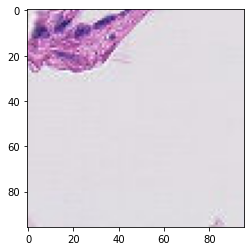

1


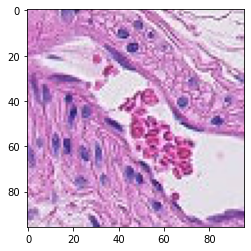

0


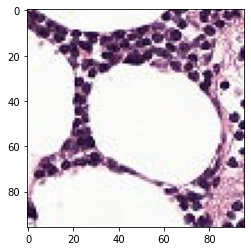

In [81]:
for i in range(3):
    img = plt.imread("C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/test/images/"+df_test.iloc[i]['id'])
    print(df_train.iloc[i]['label'])
    plt.imshow(img)
    plt.show()

In [ ]:
######## this only the first time !!

In [ ]:
# Inside train_dir folder we create seperate folders for each class
#print(os.listdir(train_dir))

no_tumor = os.path.join(train_dir, '0')
os.mkdir(no_tumor)
has_tumor = os.path.join(train_dir, '1')
os.mkdir(has_tumor)

#print(os.listdir(train_dir))

In [ ]:
print(os.listdir(train_dir))

In [ ]:
df_train.set_index('id', inplace=True)

In [ ]:
# Transfer the train images
train_list = list(df_train.index) 

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_train.loc[image,'label']
    
    # these must match the folder names
    if target == '0':
        label = '0'
    if target == '1':
        label = '1'
    
    # source path to image
    src = os.path.join('../data/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.move(src, dst)

In [82]:
print(len(os.listdir('../data/train/0')))
print(len(os.listdir('../data/train/1')))
print(len(os.listdir('../data/train')))
print(len(os.listdir('../data/test/images')))

130908
89117
2
57458


In [83]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [84]:
datagen = ImageDataGenerator(
       horizontal_flip=True,
       vertical_flip=True,
       brightness_range=[0.5, 1.5],
       fill_mode='reflect',                               
       rotation_range=15,
       rescale=1./255, # normalize image vectors
       shear_range=0.2,
       zoom_range=0.2,
       validation_split=0.15
       )
train_data = datagen.flow_from_directory(
                'C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/',
                target_size=(96, 96),
                classes=['0', '1'],
                batch_size=64,
                shuffle=True,    
                subset='training',
                class_mode='binary'
                )
validation_data = datagen.flow_from_directory(
                'C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/train/',
                target_size=(96, 96),
                classes=['0', '1'],
                batch_size=64,
                shuffle=False,    
                subset='validation',
                class_mode='binary'
                )

test_datagen = ImageDataGenerator(rescale=1./255)


Found 187022 images belonging to 2 classes.
Found 33003 images belonging to 2 classes.


In [85]:
validation_data[1]

(array([[[[0.60784316, 0.38823533, 0.6156863 ],
          [0.3529412 , 0.18039216, 0.4039216 ],
          [0.24705884, 0.09019608, 0.32941177],
          ...,
          [0.3137255 , 0.1137255 , 0.39607847],
          [0.37647063, 0.19215688, 0.4666667 ],
          [0.3529412 , 0.18431373, 0.45882356]],
 
         [[0.37647063, 0.14901961, 0.37647063],
          [0.30588236, 0.11764707, 0.34901962],
          [0.27058825, 0.11764707, 0.3647059 ],
          ...,
          [0.34509805, 0.14509805, 0.40784317],
          [0.27450982, 0.09411766, 0.36078432],
          [0.3137255 , 0.14117648, 0.41960788]],
 
         [[0.46274513, 0.2627451 , 0.4784314 ],
          [0.43137258, 0.26666668, 0.4784314 ],
          [0.2627451 , 0.12156864, 0.3529412 ],
          ...,
          [0.5058824 , 0.3254902 , 0.5372549 ],
          [0.33333334, 0.16470589, 0.3921569 ],
          [0.2784314 , 0.1137255 , 0.3647059 ]],
 
         ...,
 
         [[0.1254902 , 0.03529412, 0.28235295],
          [0.14901

In [ ]:
# dataset generation 

#train_datagen = ImageDataGenerator(
       # horizontal_flip=True,
       #vertical_flip=True,
       #brightness_range=[0.5, 1.5],
       #fill_mode='reflect',                               
        #rotation_range=15,
#        rescale=1./255, # normalize image vectors
        #shear_range=0.2,
        #zoom_range=0.2
#        validation_split=0.15
    
#)

#test_datagen = ImageDataGenerator(rescale=1./255)



#train_generator = train_datagen.flow_from_dataframe(
#                dataframe=df_train,
#                directory=train_dir,
#                x_col = 'id',
#                y_col = 'label',
# classes=["0", "1"],
#                has_ext=False,
#                subset='training',
#                target_size=(96, 96),
#                batch_size=64,
#                shuffle = True,
#                class_mode='binary',
#                validate_filenames = False
#                )

#validation_generator = train_datagen.flow_from_dataframe(
#                dataframe=df_train,
#                directory=valid_dir,
#                x_col = 'id',
#                y_col = 'label',
#                classes=["0", "1"],
##                has_ext=False,
#                subset='validation', # This is the trick to properly separate train and validation dataset
#                target_size=(96, 96),
#                batch_size=64,
#                shuffle=False,
#                class_mode='binary',
#                validate_filenames = False
#                )



In [86]:
# model definition
my_kernel_size = (3,3)
my_pool_size= (2,2)
dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = my_kernel_size, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters = 16, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 16, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = my_pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(filters = 32, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 32, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 32, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = my_pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(filters = 64, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 64, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 64, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = my_pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(filters = 128, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 128, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters = 128, kernel_size = my_kernel_size, padding = 'same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = my_pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = 'sigmoid'))


model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 96, 96, 16)        2304      
_________________________________________________________________
batch_normalization_30 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
activation_30 (Activation)   (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 96, 96, 16)        2304      
_________________________________________________________________
batch_normalization_31 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
activation_31 (Activation)   (None, 96, 96, 16)       

In [88]:
# training the model
model.compile(optimizer= optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [89]:
# Get the labels that are associated with each index
print(validation_data.class_indices)

{'0': 0, '1': 1}


In [90]:

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H%M%S")
print("date and time =", dt_string)
filepath = "model_"+ dt_string +".h5"
print(filepath)

date and time = 04092020_214611
model_04092020_214611.h5


In [91]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, 
                                   verbose=1, mode='auto', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]


In [92]:

STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=validation_data.n//validation_data.batch_size

history = model.fit(train_data,
            steps_per_epoch=STEP_SIZE_TRAIN,
            epochs=15,
            validation_data=validation_data,
            validation_steps=STEP_SIZE_VALID,
            verbose = 1,
            callbacks = callbacks_list)

Epoch 1/15
2922/2922 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7902
Epoch 00001: val_accuracy improved from -inf to 0.81393, saving model to model_04092020_214611.h5
2922/2922 [==============================] - 7459s 3s/step - loss: 0.4579 - accuracy: 0.7902 - val_loss: 0.4111 - val_accuracy: 0.8139
Epoch 2/15
2922/2922 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.8467
Epoch 00002: val_accuracy improved from 0.81393 to 0.86823, saving model to model_04092020_214611.h5
2922/2922 [==============================] - 7260s 2s/step - loss: 0.3592 - accuracy: 0.8467 - val_loss: 0.3272 - val_accuracy: 0.8682
Epoch 3/15
2922/2922 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8688
Epoch 00003: val_accuracy improved from 0.86823 to 0.87294, saving model to model_04092020_214611.h5
2922/2922 [==============================] - 7286s 2s/step - loss: 0.3162 - accuracy: 0.8688 - val_loss: 0.3118 - val_accuracy: 0.8729
E

In [93]:
history


In [94]:
model.metrics_names

['loss', 'accuracy']

In [95]:
model.weights

[<tf.Variable 'conv2d_51/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
 array([[[[-1.24964364e-01,  7.68065691e-01,  5.08391224e-02,
           -4.08957601e-01,  7.70309925e-01,  3.29787433e-02,
            2.04443526e+00, -2.08728343e-01, -6.96062222e-02,
           -6.41847551e-01, -5.35796583e-01, -2.45680347e-01,
           -7.38624930e-02, -1.47424087e-01,  2.84064692e-02,
            3.77552599e-01],
          [-2.83219963e-01, -1.23954415e-01, -1.54649809e-01,
           -8.80425572e-02, -4.39747244e-01, -5.94686419e-02,
           -1.38735127e+00, -2.73349565e-02, -1.48875220e-02,
           -1.33442366e+00, -8.44441116e-01, -5.52767888e-02,
           -2.96254039e-01, -1.85597256e-01,  8.18958208e-02,
           -1.96276709e-01],
          [-2.82687932e-01,  2.13924384e+00, -2.21612081e-01,
           -1.83573291e-01, -3.83235365e-01, -4.43929955e-02,
           -7.14278221e-02,  9.94459633e-03, -6.79360703e-02,
           -2.93320715e-01, -7.26915658e-01,  8.55171904e-0

In [96]:
test_data = test_datagen.flow_from_directory('C:/Users/elisa/PycharmProjects/kaggle_histopathologic_cancer/data/test/',
                                        target_size=(96, 96),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)


Found 57458 images belonging to 1 classes.


In [97]:
from glob import glob
from skimage.io import imread

test_files = glob(os.path.join(test_dir + '/images','*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)


In [98]:
test_files[1].split('/')[-1].split('\\')[-1].split(".")[0]

'0000ec92553fda4ce39889f9226ace43cae3364e'

In [99]:
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[-1].split('\\')[-1].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.000006
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.000261
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.000012
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.010143
4,000270442cc15af719583a8172c87cd2bd9c7746,0.000539


In [101]:
submission.tail()

,id,label
2453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0.006230
2454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0.003945
2455,fffec7da56b54258038b0d382b3d55010eceb9d7,0.002315
2456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0.000067
2457,ffffeb4c0756098c7f589b7beec08ef1899093b5,0.000191


In [100]:
submission.label.max()

0.9999099

In [102]:
submission.to_csv("../submission/submission_"+dt_string+".csv", index = False, header = True)

In [103]:

val_loss, val_acc = model.evaluate(validation_data)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

516/516 [==============================] - 330s 640ms/step - loss: 0.1851 - accuracy: 0.9296
val_loss: 0.1851307451725006
val_acc: 0.9295821785926819


In [104]:
predictions = model.predict(test_data, verbose=1)

57458/57458 [==============================] - 698s 12ms/step


In [105]:
print(predictions.shape)
print(test_data.class_indices)

(57458, 1)
{'images': 0}


In [106]:
predictions

array([[0.9943993 ],
       [0.97641575],
       [0.51586974],
       ...,
       [0.0235762 ],
       [0.00340852],
       [0.12499645]], dtype=float32)

In [107]:
test_labels = test_data.classes

In [117]:
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed
#set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


NameError: name 'plot_confusion_matrix' is not defined